# CSE 572 – HW3 Task 2: Recommender Systems with Surprise

This notebook implements:
- Loading `ratings_small.csv`
- PMF-like MF (SVD), User-based CF, Item-based CF
- MAE and RMSE evaluation with 5-fold cross-validation
- Effect of similarity metrics (cosine, MSD, Pearson)
- Effect of neighbor count K and best K selection

MAE and RMSE are defined as in the references you provided. MAE is the mean absolute difference between predictions and true values, while RMSE is the square root of the mean squared difference. [attached_file:1][attached_file:2]

In [1]:
# If running in a fresh environment, install scikit-surprise first
# Uncomment the following lines if needed:
!pip install "numpy<2" scikit-surprise

import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import KFold
from surprise import accuracy
from collections import defaultdict

print("Libraries imported.")

Libraries imported.


## Load ratings data

The CSV `ratings_small.csv` should be in the same directory as this notebook. The format is: `userId,movieId,rating,timestamp`.

In [2]:
ratings = pd.read_csv("ratings_small.csv")
print(ratings.head())
print("Shape:", ratings.shape)

# Define a Reader with rating scale used in MovieLens small (0.5–5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset for Surprise
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
print("Data loaded into Surprise format.")

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
Shape: (100004, 4)
Data loaded into Surprise format.


## Helper: 5-fold cross-validation for MAE and RMSE

This function returns average MAE and RMSE across folds.

In [3]:
def evaluate_algo(algo, data, n_splits=5, verbose=True):
    """Perform K-fold CV and return mean MAE and RMSE."""
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    mae_scores, rmse_scores = [], []

    for fold, (trainset, testset) in enumerate(kf.split(data), 1):
        algo.fit(trainset)
        predictions = algo.test(testset)
        mae = accuracy.mae(predictions, verbose=False)
        rmse = accuracy.rmse(predictions, verbose=False)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        if verbose:
            print(f"Fold {fold}: MAE={mae:.4f}, RMSE={rmse:.4f}")

    mean_mae = sum(mae_scores) / len(mae_scores)
    mean_rmse = sum(rmse_scores) / len(rmse_scores)
    if verbose:
        print(f"Average: MAE={mean_mae:.4f}, RMSE={mean_rmse:.4f}")
    return mean_mae, mean_rmse

print("Evaluation helper defined.")

Evaluation helper defined.


## (c) PMF, UserCF, ItemCF – Average MAE & RMSE (5-fold)

PMF is approximated here with `SVD` (a matrix factorization model) from Surprise. User-based and Item-based CF are implemented with `KNNBasic`.

In [4]:
results_c = {}

# PMF-style MF using SVD
pmf_algo = SVD(random_state=42)
print("Evaluating PMF (SVD)...")
mae_pmf, rmse_pmf = evaluate_algo(pmf_algo, data)
results_c["PMF"] = {"MAE": mae_pmf, "RMSE": rmse_pmf}

# User-based CF (default similarity is cosine)
user_cf_algo = KNNBasic(sim_options={"user_based": True}, verbose=False)
print("\nEvaluating User-based CF (default similarity)...")
mae_u, rmse_u = evaluate_algo(user_cf_algo, data)
results_c["UserCF"] = {"MAE": mae_u, "RMSE": rmse_u}

# Item-based CF
item_cf_algo = KNNBasic(sim_options={"user_based": False}, verbose=False)
print("\nEvaluating Item-based CF (default similarity)...")
mae_i, rmse_i = evaluate_algo(item_cf_algo, data)
results_c["ItemCF"] = {"MAE": mae_i, "RMSE": rmse_i}

print("\nSummary (Task 2c):")
for model, metrics in results_c.items():
    print(f"{model}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

Evaluating PMF (SVD)...
Fold 1: MAE=0.6909, RMSE=0.8972
Fold 2: MAE=0.6880, RMSE=0.8918
Fold 3: MAE=0.6933, RMSE=0.8992
Fold 4: MAE=0.6871, RMSE=0.8940
Fold 5: MAE=0.6954, RMSE=0.9024
Average: MAE=0.6909, RMSE=0.8969

Evaluating User-based CF (default similarity)...
Fold 1: MAE=0.7451, RMSE=0.9681
Fold 2: MAE=0.7394, RMSE=0.9639
Fold 3: MAE=0.7479, RMSE=0.9714
Fold 4: MAE=0.7408, RMSE=0.9684
Fold 5: MAE=0.7456, RMSE=0.9672
Average: MAE=0.7437, RMSE=0.9678

Evaluating Item-based CF (default similarity)...
Fold 1: MAE=0.7172, RMSE=0.9295
Fold 2: MAE=0.7169, RMSE=0.9281
Fold 3: MAE=0.7227, RMSE=0.9396
Fold 4: MAE=0.7178, RMSE=0.9323
Fold 5: MAE=0.7306, RMSE=0.9433
Average: MAE=0.7210, RMSE=0.9346

Summary (Task 2c):
PMF: MAE=0.6909, RMSE=0.8969
UserCF: MAE=0.7437, RMSE=0.9678
ItemCF: MAE=0.7210, RMSE=0.9346


## (d) Compare average performances and choose best model

Use the printed `results_c` to argue in your report which model is best in terms of RMSE and MAE for this dataset. The model with the lowest RMSE is usually preferred as it penalizes larger errors more strongly. [attached_file:1][attached_file:2]

## (e) Effect of similarity metrics (cosine, MSD, Pearson)

Evaluate UserCF and ItemCF with three similarity metrics and plot RMSE and MAE.

In [5]:
similarities = ["cosine", "msd", "pearson"]
user_cf_sim_results = {}
item_cf_sim_results = {}

for sim in similarities:
    print(f"\nEvaluating similarity: {sim} (UserCF)")
    sim_opt_user = {"name": sim, "user_based": True}
    user_algo = KNNBasic(sim_options=sim_opt_user, verbose=False)
    mae_u, rmse_u = evaluate_algo(user_algo, data, verbose=False)
    user_cf_sim_results[sim] = (mae_u, rmse_u)
    print(f"UserCF-{sim}: MAE={mae_u:.4f}, RMSE={rmse_u:.4f}")

    print(f"Evaluating similarity: {sim} (ItemCF)")
    sim_opt_item = {"name": sim, "user_based": False}
    item_algo = KNNBasic(sim_options=sim_opt_item, verbose=False)
    mae_i, rmse_i = evaluate_algo(item_algo, data, verbose=False)
    item_cf_sim_results[sim] = (mae_i, rmse_i)
    print(f"ItemCF-{sim}: MAE={mae_i:.4f}, RMSE={rmse_i:.4f}")

print("\nUserCF similarity results:")
print(user_cf_sim_results)
print("ItemCF similarity results:")
print(item_cf_sim_results)


Evaluating similarity: cosine (UserCF)
UserCF-cosine: MAE=0.7671, RMSE=0.9931
Evaluating similarity: cosine (ItemCF)
ItemCF-cosine: MAE=0.7748, RMSE=0.9951

Evaluating similarity: msd (UserCF)
UserCF-msd: MAE=0.7437, RMSE=0.9678
Evaluating similarity: msd (ItemCF)
ItemCF-msd: MAE=0.7210, RMSE=0.9346

Evaluating similarity: pearson (UserCF)
UserCF-pearson: MAE=0.7731, RMSE=0.9983
Evaluating similarity: pearson (ItemCF)
ItemCF-pearson: MAE=0.7685, RMSE=0.9891

UserCF similarity results:
{'cosine': (0.767112764950549, 0.9931497533264565), 'msd': (0.7437347849319995, 0.9677786765388319), 'pearson': (0.7730514995775345, 0.9983420094767474)}
ItemCF similarity results:
{'cosine': (0.774791925501196, 0.9950999217718216), 'msd': (0.7210454050023356, 0.9345691106428742), 'pearson': (0.7685002885212805, 0.9891427265191097)}


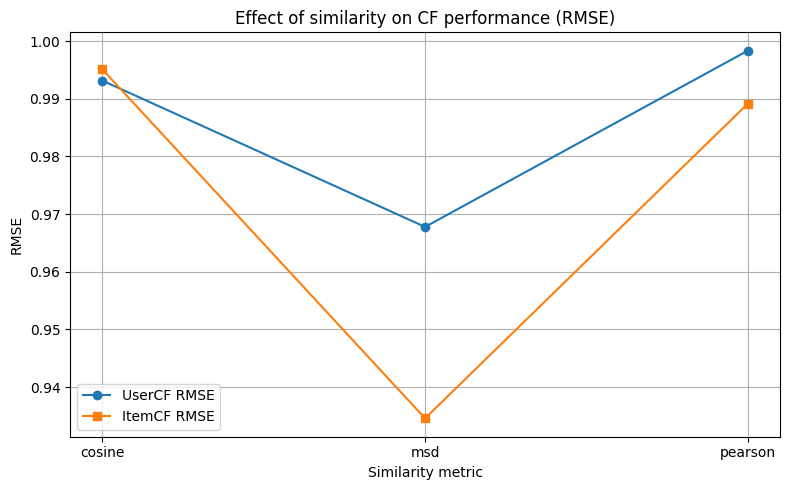

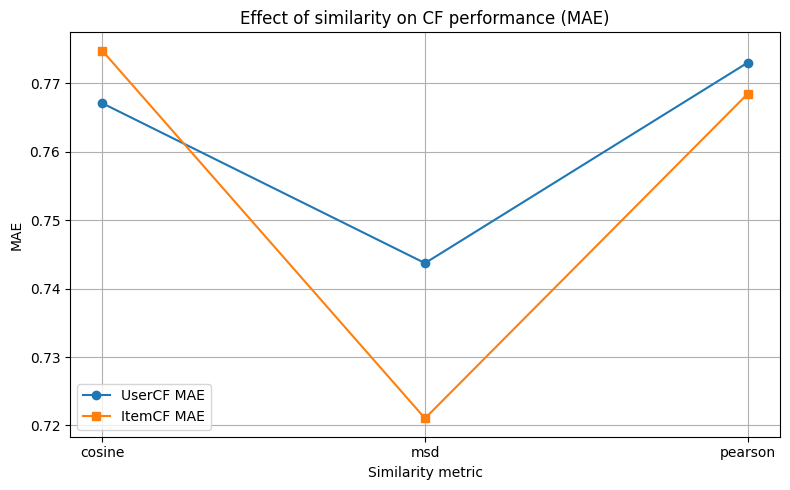

In [6]:
# Plot RMSE vs similarity
x = range(len(similarities))

plt.figure(figsize=(8,5))
plt.plot(x, [user_cf_sim_results[s][1] for s in similarities],
         marker='o', label='UserCF RMSE')
plt.plot(x, [item_cf_sim_results[s][1] for s in similarities],
         marker='s', label='ItemCF RMSE')
plt.xticks(x, similarities)
plt.xlabel("Similarity metric")
plt.ylabel("RMSE")
plt.title("Effect of similarity on CF performance (RMSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs similarity
plt.figure(figsize=(8,5))
plt.plot(x, [user_cf_sim_results[s][0] for s in similarities],
         marker='o', label='UserCF MAE')
plt.plot(x, [item_cf_sim_results[s][0] for s in similarities],
         marker='s', label='ItemCF MAE')
plt.xticks(x, similarities)
plt.xlabel("Similarity metric")
plt.ylabel("MAE")
plt.title("Effect of similarity on CF performance (MAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## (f) Effect of number of neighbors K

Here we vary K for UserCF and ItemCF using cosine similarity and measure MAE and RMSE for each value of K.

In [7]:
neighbor_values = [5, 10, 20, 30, 40, 50, 60, 80]
user_cf_k_results = {}
item_cf_k_results = {}

for k in neighbor_values:
    print(f"\nEvaluating K={k} (UserCF, cosine)")
    user_algo_k = KNNBasic(k=k,
                           sim_options={"name": "cosine", "user_based": True},
                           verbose=False)
    mae_u, rmse_u = evaluate_algo(user_algo_k, data, verbose=False)
    user_cf_k_results[k] = (mae_u, rmse_u)
    print(f"UserCF K={k}: MAE={mae_u:.4f}, RMSE={rmse_u:.4f})")

    print(f"Evaluating K={k} (ItemCF, cosine)")
    item_algo_k = KNNBasic(k=k,
                           sim_options={"name": "cosine", "user_based": False},
                           verbose=False)
    mae_i, rmse_i = evaluate_algo(item_algo_k, data, verbose=False)
    item_cf_k_results[k] = (mae_i, rmse_i)
    print(f"ItemCF K={k}: MAE={mae_i:.4f}, RMSE={rmse_i:.4f})")

print("\nUserCF K results:")
print(user_cf_k_results)
print("ItemCF K results:")
print(item_cf_k_results)


Evaluating K=5 (UserCF, cosine)
UserCF K=5: MAE=0.8050, RMSE=1.0440)
Evaluating K=5 (ItemCF, cosine)
ItemCF K=5: MAE=0.8596, RMSE=1.1009)

Evaluating K=10 (UserCF, cosine)
UserCF K=10: MAE=0.7771, RMSE=1.0091)
Evaluating K=10 (ItemCF, cosine)
ItemCF K=10: MAE=0.8212, RMSE=1.0508)

Evaluating K=20 (UserCF, cosine)
UserCF K=20: MAE=0.7682, RMSE=0.9966)
Evaluating K=20 (ItemCF, cosine)
ItemCF K=20: MAE=0.7941, RMSE=1.0171)

Evaluating K=30 (UserCF, cosine)
UserCF K=30: MAE=0.7668, RMSE=0.9939)
Evaluating K=30 (ItemCF, cosine)
ItemCF K=30: MAE=0.7820, RMSE=1.0031)

Evaluating K=40 (UserCF, cosine)
UserCF K=40: MAE=0.7671, RMSE=0.9931)
Evaluating K=40 (ItemCF, cosine)
ItemCF K=40: MAE=0.7748, RMSE=0.9951)

Evaluating K=50 (UserCF, cosine)
UserCF K=50: MAE=0.7678, RMSE=0.9932)
Evaluating K=50 (ItemCF, cosine)
ItemCF K=50: MAE=0.7697, RMSE=0.9894)

Evaluating K=60 (UserCF, cosine)
UserCF K=60: MAE=0.7683, RMSE=0.9933)
Evaluating K=60 (ItemCF, cosine)
ItemCF K=60: MAE=0.7664, RMSE=0.9858)

Ev

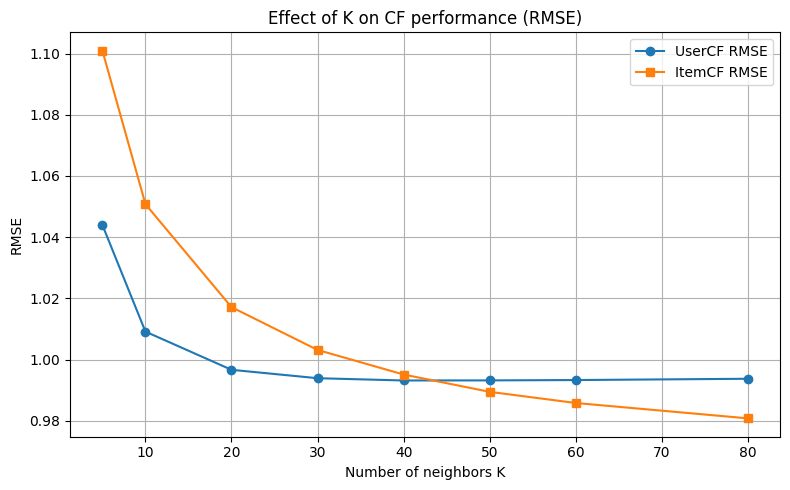

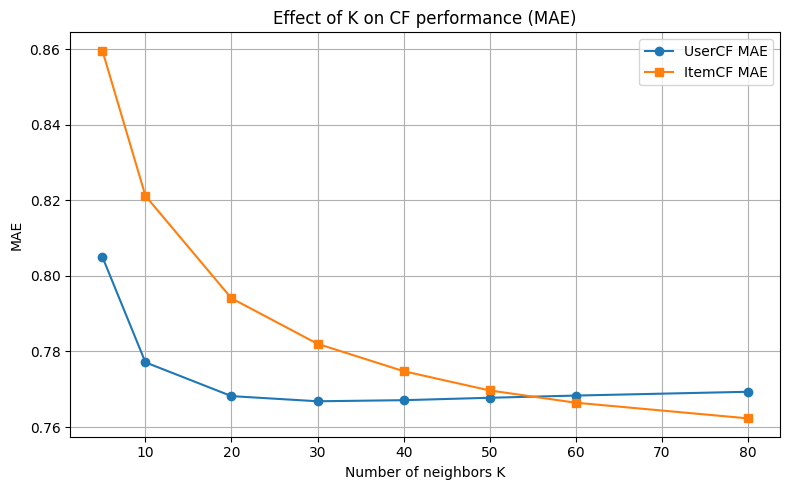

In [8]:
# Plot RMSE vs K
plt.figure(figsize=(8,5))
plt.plot(neighbor_values,
         [user_cf_k_results[k][1] for k in neighbor_values],
         marker='o', label='UserCF RMSE')
plt.plot(neighbor_values,
         [item_cf_k_results[k][1] for k in neighbor_values],
         marker='s', label='ItemCF RMSE')
plt.xlabel("Number of neighbors K")
plt.ylabel("RMSE")
plt.title("Effect of K on CF performance (RMSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs K
plt.figure(figsize=(8,5))
plt.plot(neighbor_values,
         [user_cf_k_results[k][0] for k in neighbor_values],
         marker='o', label='UserCF MAE')
plt.plot(neighbor_values,
         [item_cf_k_results[k][0] for k in neighbor_values],
         marker='s', label='ItemCF MAE')
plt.xlabel("Number of neighbors K")
plt.ylabel("MAE")
plt.title("Effect of K on CF performance (MAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## (g) Best K for UserCF and ItemCF (by RMSE)

Select the K with the lowest RMSE for each method and report whether they are equal or different.

In [9]:
best_k_user = min(neighbor_values, key=lambda k: user_cf_k_results[k][1])
best_k_item = min(neighbor_values, key=lambda k: item_cf_k_results[k][1])

print("Best K for User-based CF (by RMSE):", best_k_user,
      "with RMSE:", user_cf_k_results[best_k_user][1])

print("Best K for Item-based CF (by RMSE):", best_k_item,
      "with RMSE:", item_cf_k_results[best_k_item][1])

Best K for User-based CF (by RMSE): 40 with RMSE: 0.9931497533264565
Best K for Item-based CF (by RMSE): 80 with RMSE: 0.9807769218176622
